# Rolling Sales Feautres

This notebook aims to explore the impact of economic features on sales. Questions this notebook aims to answer include: 
1. How does ecnomic features impact sales for items in different departments?
2. How are items individuall affected by economic indicators? 
3. What is the best way to signal the model the nature of the individual item based on this features?

An important piece of information is that 2011 is not a complete date. This is what was driving the odd rolling averages. I need to fix this everywhere. 
Like wise I have learned that the last month (2016-03) is incomplete. I will filter it now. 

My conclussion here is that after applying differencing, these features lose their predictive value as the majority of it revovled around capturing the downard trend of the sales.

In [20]:
# Import required libraries
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.metrics import dtw
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import numpy as np

project_root = os.path.abspath(os.path.join(os.getcwd(), "..", "..", "..", ".."))
sys.path.append(project_root)

# Now you can import from core if needed
from src.core.clients.bigquery import BigQueryClient

bq_client = BigQueryClient()

sales_query = """
    SELECT 
        tgt.ctx_date_month,
        tgt.ctx_cat_id, 
        tgt.ctx_dept_id, 
        tgt.ctx_item_id,
        tgt.tgt_monthly_sales,
        tgt.tgt_monthly_sales_sum_3_next_months
    FROM `porygon-pipelines.walmart_targets_and_filters.target_store_item_monthly` tgt
    LEFT JOIN `porygon-pipelines.walmart_targets_and_filters.stockout_filter` stckt
        ON tgt.ctx_item_id = stckt.ctx_item_id
        AND tgt.ctx_store_id = stckt.ctx_store_id
        AND tgt.ctx_date_month = stckt.ctx_date_month
    WHERE 
        tgt.ctx_store_id = 'CA_1'
        AND stckt.is_stockout_tgt = 0
"""

roll_feas_query = """
    SELECT 
        roll.ctx_date_month,
        roll.ctx_item_id,
        roll.ctx_store_id,
        roll.fea_item_monthly_sales,
        roll.fea_num_days_item_is_zero_sales,
        roll.fea_item_monthly_sales_roll_avg_3_months,
        roll.fea_item_monthly_sales_roll_avg_6_months,
        roll.fea_item_monthly_sales_roll_avg_12_months,
        roll.fea_item_monthly_sales_roll_std_3_months,
        roll.fea_item_monthly_sales_roll_std_6_months,
        roll.fea_item_monthly_sales_roll_std_12_months,
        roll.fea_item_monthly_sales_percent_change,
        roll.fea_item_monthly_sales_lag_1_months,
        roll.fea_item_monthly_sales_lag_2_months,
        roll.fea_item_monthly_sales_lag_3_months,
        roll.fea_item_monthly_sales_lag_4_months,
        roll.fea_num_days_item_is_zero_sales_roll_avg_3_months,
        roll.fea_num_days_item_is_zero_sales_roll_avg_6_months,
        roll.fea_num_days_item_is_zero_sales_roll_avg_12_months,
        roll.fea_num_days_item_is_zero_sales_roll_std_3_months,
        roll.fea_num_days_item_is_zero_sales_roll_std_6_months,
        roll.fea_num_days_item_is_zero_sales_roll_std_12_months,
        roll.fea_num_days_item_is_zero_sales_lag_1_months,
        roll.fea_state_item_monthly_sales,
        roll.fea_state_item_num_days_is_zero_sales,
        roll.fea_state_item_monthly_sales_roll_avg_3_months,
        roll.fea_state_item_monthly_sales_roll_avg_6_months,
        roll.fea_state_item_monthly_sales_roll_avg_12_months,
        roll.fea_state_item_monthly_sales_roll_std_3_months,
        roll.fea_state_item_monthly_sales_roll_std_6_months,
        roll.fea_state_item_monthly_sales_roll_std_12_months,
        roll.fea_state_item_num_days_is_zero_sales_roll_avg_3_months,
        roll.fea_state_item_num_days_is_zero_sales_roll_avg_6_months,
        roll.fea_state_item_num_days_is_zero_sales_roll_avg_12_months,
        roll.fea_state_item_num_days_is_zero_sales_roll_std_3_months,
        roll.fea_state_item_num_days_is_zero_sales_roll_std_6_months,
        roll.fea_state_item_num_days_is_zero_sales_roll_std_12_months,
        roll.fea_all_item_monthly_sales,
        roll.fea_all_item_num_days_is_zero_sales,
        roll.fea_all_item_monthly_sales_roll_avg_3_months,
        roll.fea_all_item_monthly_sales_roll_avg_6_months,
        roll.fea_all_item_monthly_sales_roll_avg_12_months,
        roll.fea_all_item_monthly_sales_roll_std_3_months,
        roll.fea_all_item_monthly_sales_roll_std_6_months,
        roll.fea_all_item_monthly_sales_roll_std_12_months,
        stckt.* EXCEPT(ctx_item_id, ctx_store_id, ctx_date_month)
    FROM `porygon-pipelines.walmart_featurestore.rolling_sales_features` roll
    LEFT JOIN `porygon-pipelines.walmart_targets_and_filters.stockout_filter` stckt
        ON roll.ctx_item_id = stckt.ctx_item_id
        AND roll.ctx_store_id = stckt.ctx_store_id
        AND roll.ctx_date_month = stckt.ctx_date_month
    WHERE 
        roll.ctx_store_id = 'CA_1'
"""


# Extract data
item_sales = bq_client.load_from_query(sales_query)
roll_feas = bq_client.load_from_query(roll_feas_query)

item_sales = item_sales[
    (item_sales["ctx_date_month"]>=pd.to_datetime("2011-02-01"))
    & (item_sales["ctx_date_month"]<=pd.to_datetime("2015-11-01"))
     ]

# Merge dataframes on 'ctx_date_month'
df_merged = item_sales.merge(
    roll_feas,
    on=["ctx_date_month", "ctx_item_id",]
)


INFO:src.core.clients.bigquery:BigQuery client initialized for project: porygon-pipelines


/Users/anapreciado/Desktop/porygon-demand-forecasting/venv/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(
INFO:src.core.clients.bigquery:Loaded 121003 rows from custom query.
INFO:src.core.clients.bigquery:Loaded 155691 rows from custom query.


# Utils plot functions

In [21]:
item_sales_focus = df_merged.copy()

def plot_tgt_vs_feature(feature_name):
    fig, ax1 = plt.subplots(figsize=(12,5))
    sns.lineplot(data=item_sales_focus, x='ctx_date_month', y='tgt_monthly_sales_sum_3_next_months', marker='o', ax=ax1, color='tab:blue', label="tgt_monthly_sales_sum_3_next_months")
    ax1.set_ylabel('tgt_monthly_sales_sum_3_next_months', color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax2 = ax1.twinx()
    sns.lineplot(data=item_sales_focus, x='ctx_date_month', y=feature_name, marker='o', ax=ax2, color='tab:orange', label=feature_name)
    ax2.set_ylabel(feature_name, color='tab:orange')
    ax2.tick_params(axis='y', labelcolor='tab:orange')
    ax1.set_title(f'tgt_monthly_sales_sum_3_next_months and {feature_name} over Time')
    ax1.set_xlabel('Month')
    fig.tight_layout()
    plt.show()

# Explore Rolling Averages

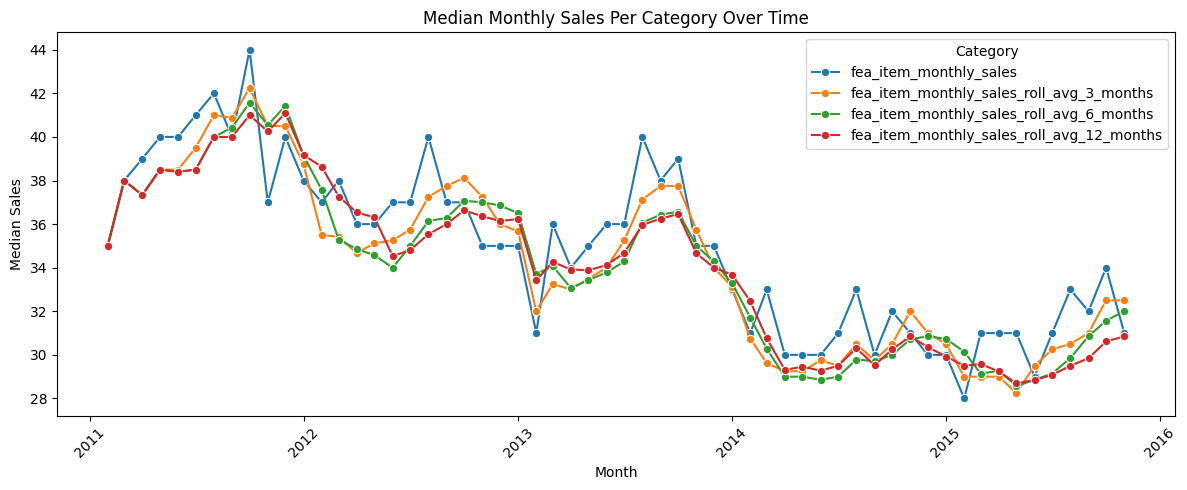

In [3]:

plt.figure(figsize=(12,5))
item_sales_focus = df_merged.copy()
sns.lineplot(
    data=item_sales_focus.groupby('ctx_date_month')['fea_item_monthly_sales'].median().reset_index(),
    x='ctx_date_month', y='fea_item_monthly_sales', marker='o', label="fea_item_monthly_sales")
sns.lineplot(
    data=item_sales_focus.groupby('ctx_date_month')['fea_item_monthly_sales_roll_avg_3_months'].median().reset_index(),
    x='ctx_date_month', y='fea_item_monthly_sales_roll_avg_3_months', marker='o', label="fea_item_monthly_sales_roll_avg_3_months")
sns.lineplot(
    data=item_sales_focus.groupby('ctx_date_month')['fea_item_monthly_sales_roll_avg_6_months'].median().reset_index(),
    x='ctx_date_month', y='fea_item_monthly_sales_roll_avg_6_months', marker='o', label="fea_item_monthly_sales_roll_avg_6_months")
sns.lineplot(
    data=item_sales_focus.groupby('ctx_date_month')['fea_item_monthly_sales_roll_avg_12_months'].median().reset_index(),
    x='ctx_date_month', y='fea_item_monthly_sales_roll_avg_12_months', marker='o', label="fea_item_monthly_sales_roll_avg_12_months")
plt.title('Median Monthly Sales Per Category Over Time')
plt.xlabel('Month')
plt.ylabel('Median Sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend(title='Category')
plt.show()

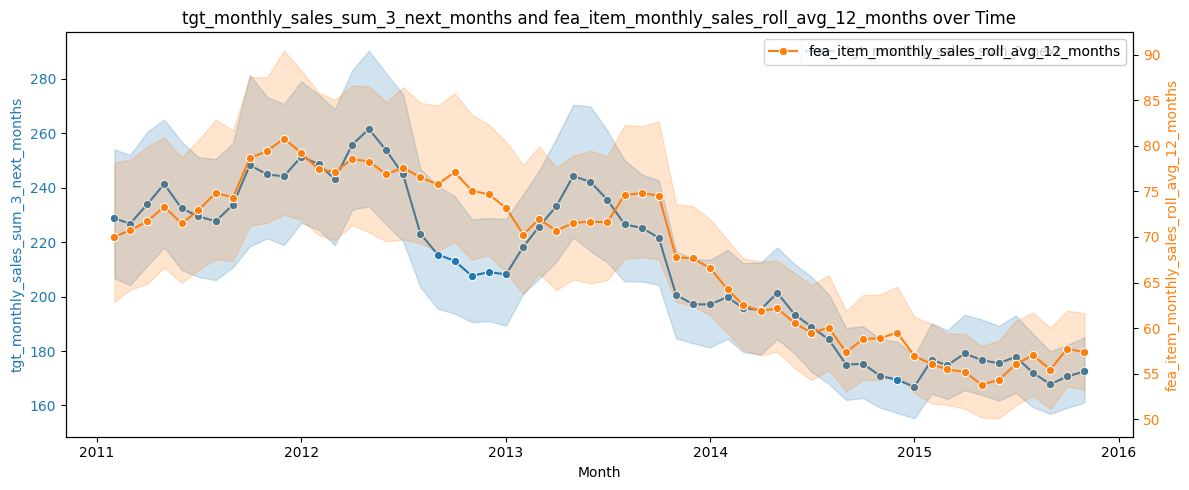

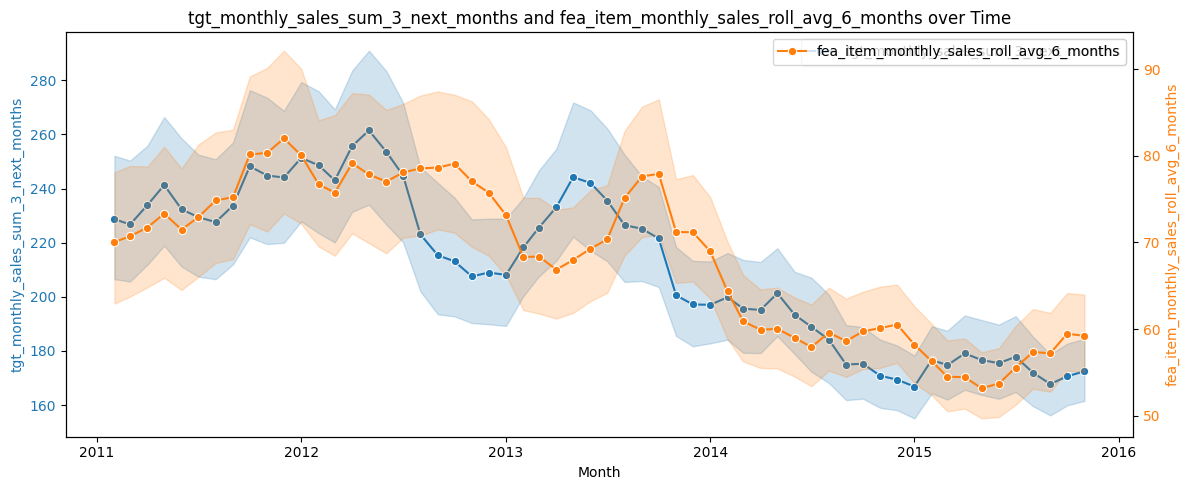

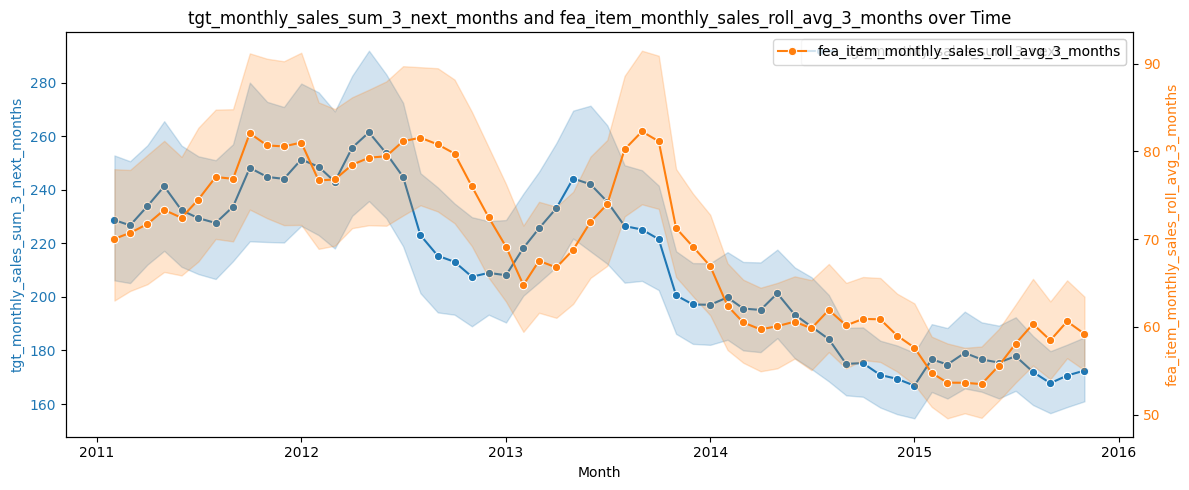

In [4]:
# Moving averages help caputre level, but they don't reac tfast enough to changes. 

plot_tgt_vs_feature("fea_item_monthly_sales_roll_avg_12_months")
plot_tgt_vs_feature("fea_item_monthly_sales_roll_avg_6_months")
plot_tgt_vs_feature("fea_item_monthly_sales_roll_avg_3_months")

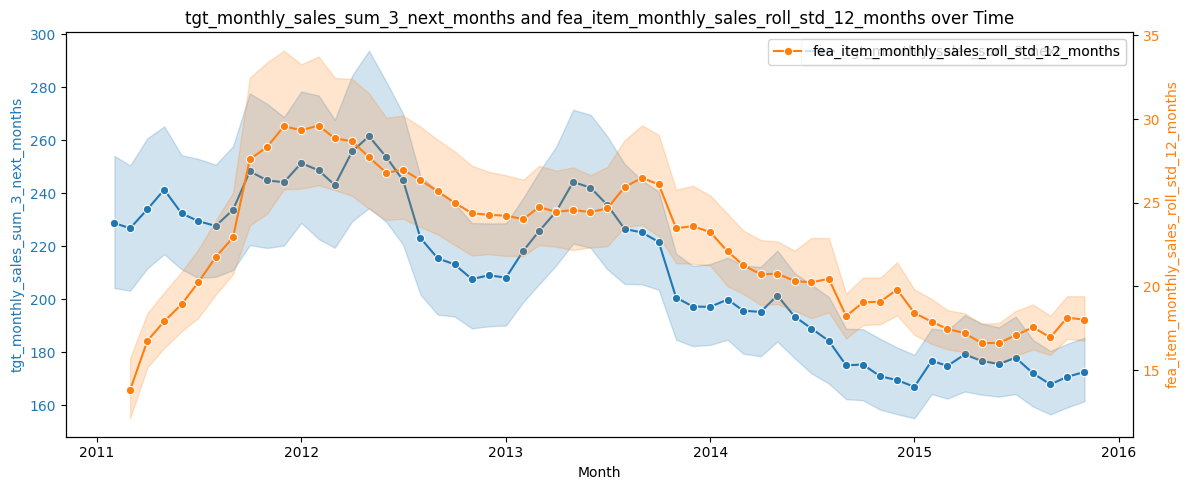

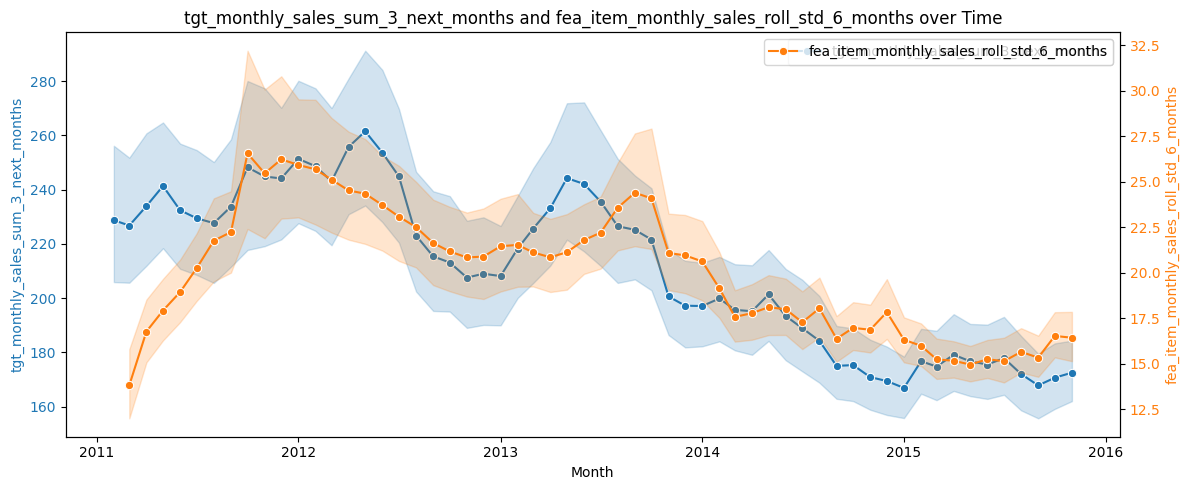

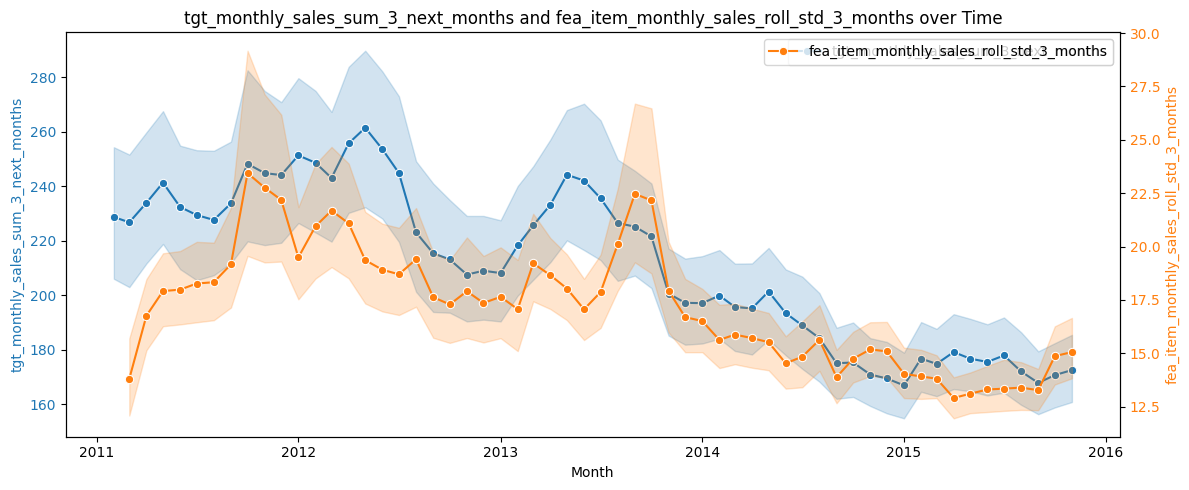

In [5]:
# the feature for standard deviation as is might be misleading as it indicates trend.
# The lower the standard deviation the lower the value. This might be good to switch for coefficient of variation instead.
# Note also that the standard deviation takes a couple of months to become reliable. 
# It may be good to wait for items to have at least 6 data points before having a value for this feature.
plot_tgt_vs_feature("fea_item_monthly_sales_roll_std_12_months")
plot_tgt_vs_feature("fea_item_monthly_sales_roll_std_6_months")
plot_tgt_vs_feature("fea_item_monthly_sales_roll_std_3_months")

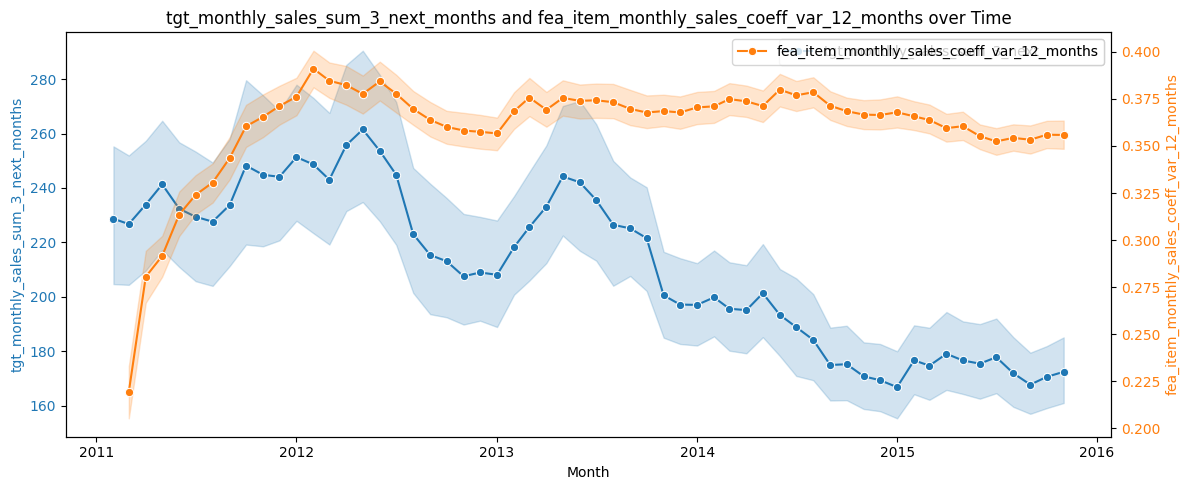

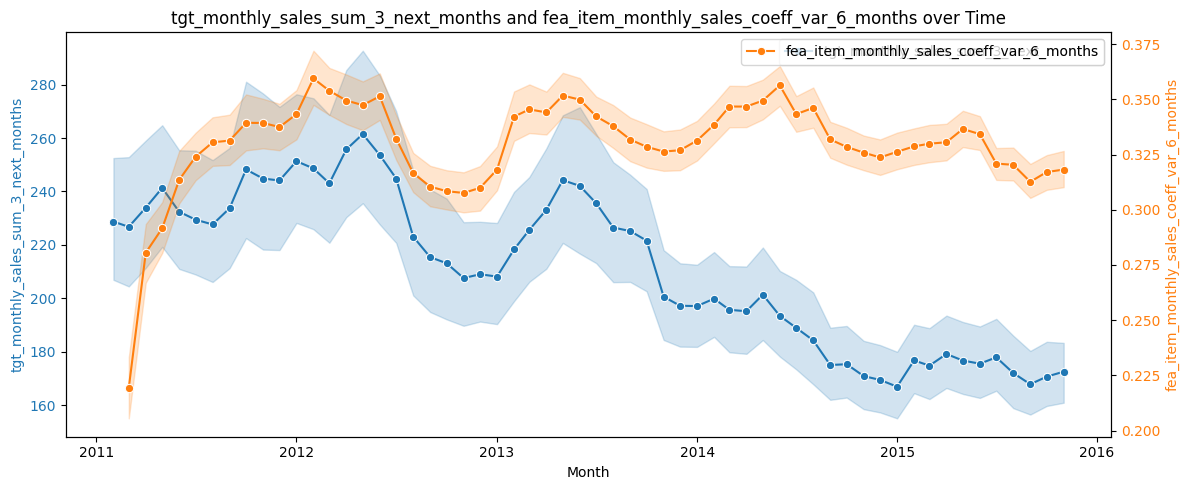

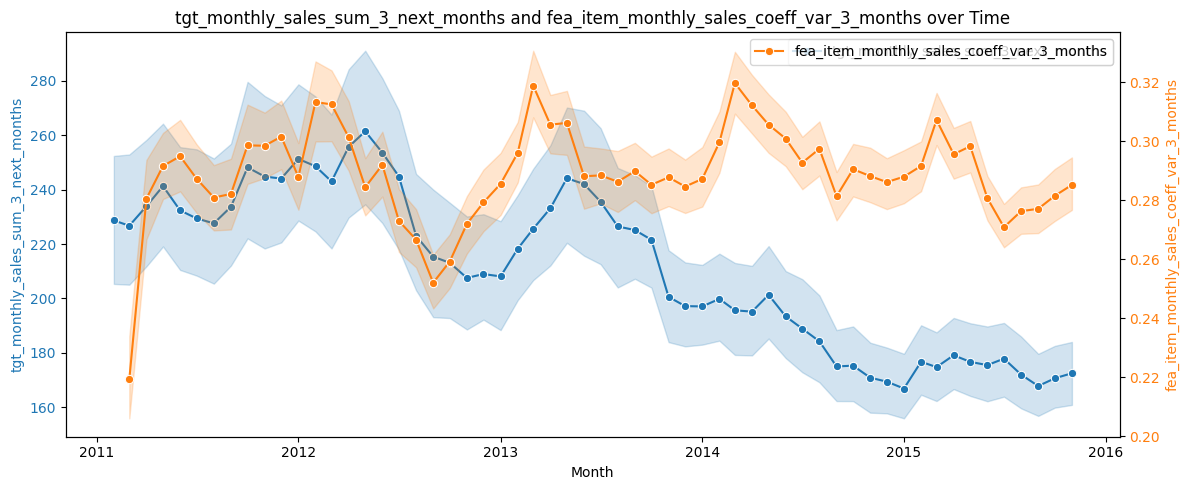

In [6]:
# fabricating coefficient of variation to pot:
item_sales_focus["fea_item_monthly_sales_coeff_var_3_months"] = item_sales_focus["fea_item_monthly_sales_roll_std_3_months"] / item_sales_focus["fea_item_monthly_sales_roll_avg_3_months"]
item_sales_focus["fea_item_monthly_sales_coeff_var_6_months"] = item_sales_focus["fea_item_monthly_sales_roll_std_6_months"] / item_sales_focus["fea_item_monthly_sales_roll_avg_6_months"]
item_sales_focus["fea_item_monthly_sales_coeff_var_12_months"] = item_sales_focus["fea_item_monthly_sales_roll_std_12_months"] / item_sales_focus["fea_item_monthly_sales_roll_avg_12_months"]

plot_tgt_vs_feature("fea_item_monthly_sales_coeff_var_12_months")
plot_tgt_vs_feature("fea_item_monthly_sales_coeff_var_6_months")
plot_tgt_vs_feature("fea_item_monthly_sales_coeff_var_3_months")

# Notes: 
# 1. does not capture the trend, but rather the actual variation (seems like).
# 2. Has the potential of capturing the variability in the short term.

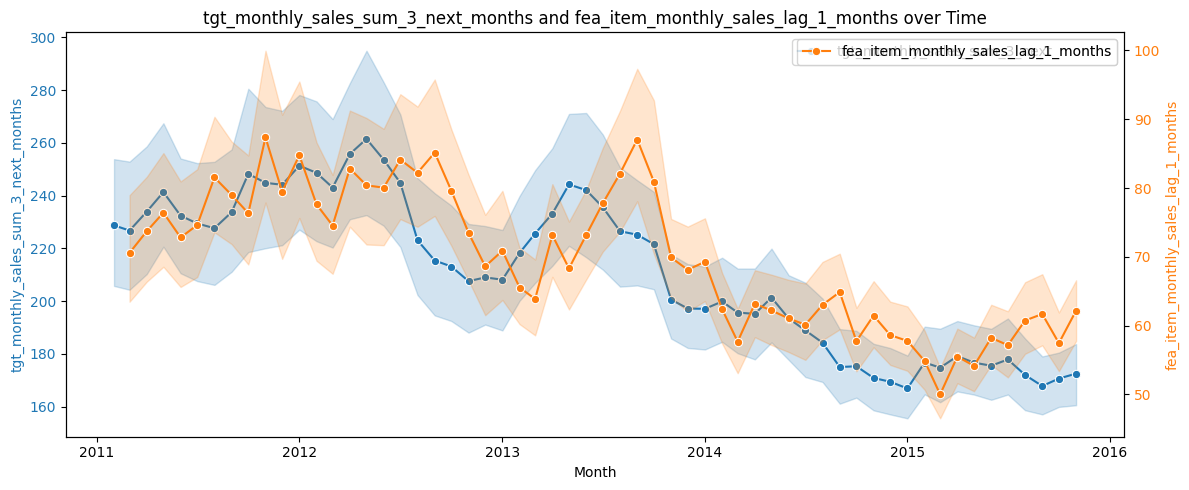

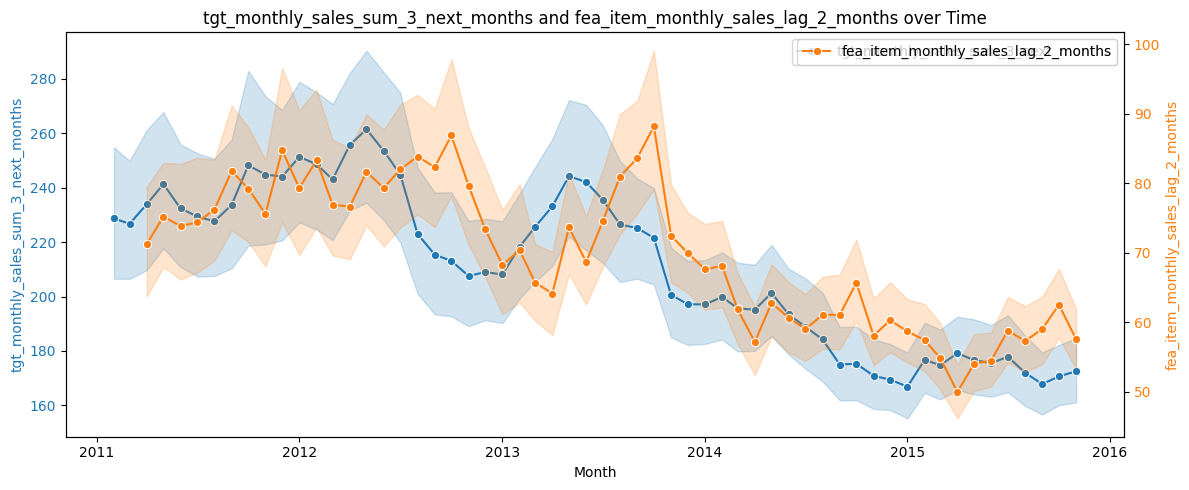

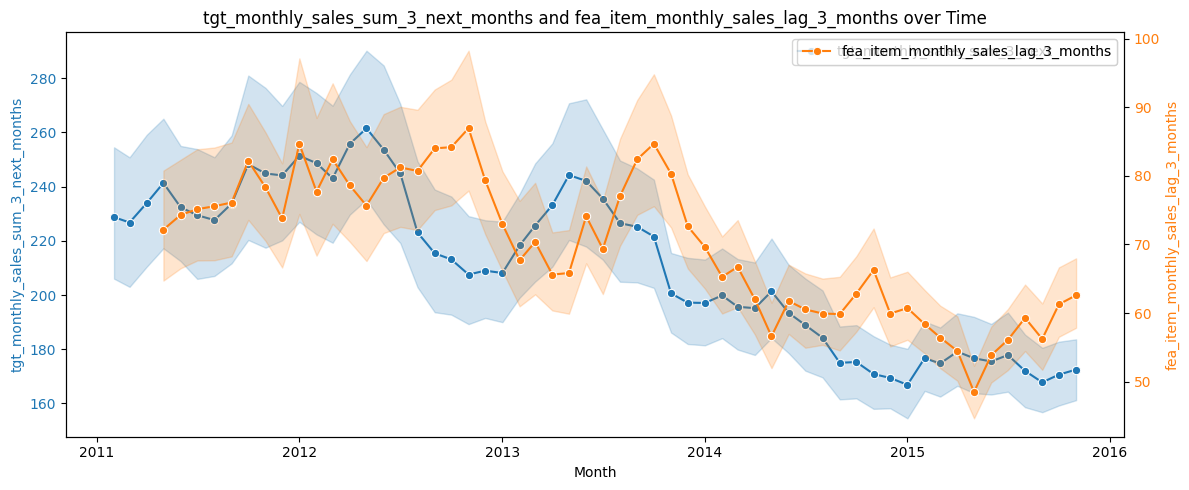

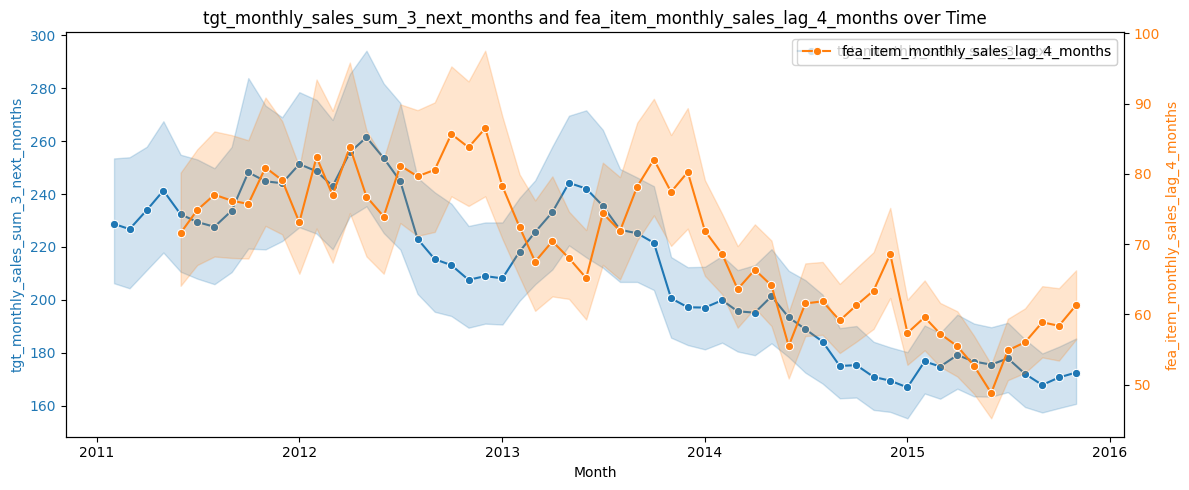

In [7]:
# the feature for standard deviation as is might be misleading as it indicates trend.
# The lower the standard deviation the lower the value. This might be good to switch for coefficient of variation instead.
plot_tgt_vs_feature("fea_item_monthly_sales_lag_1_months")
plot_tgt_vs_feature("fea_item_monthly_sales_lag_2_months")
plot_tgt_vs_feature("fea_item_monthly_sales_lag_3_months")
plot_tgt_vs_feature("fea_item_monthly_sales_lag_4_months")
# I do believe this features will become relevant after the application of differencing. 

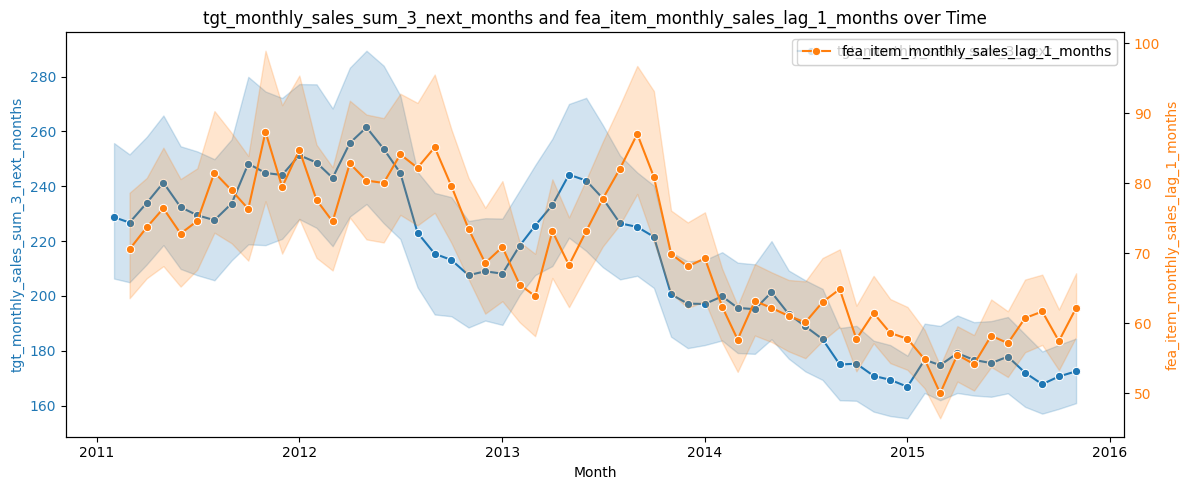

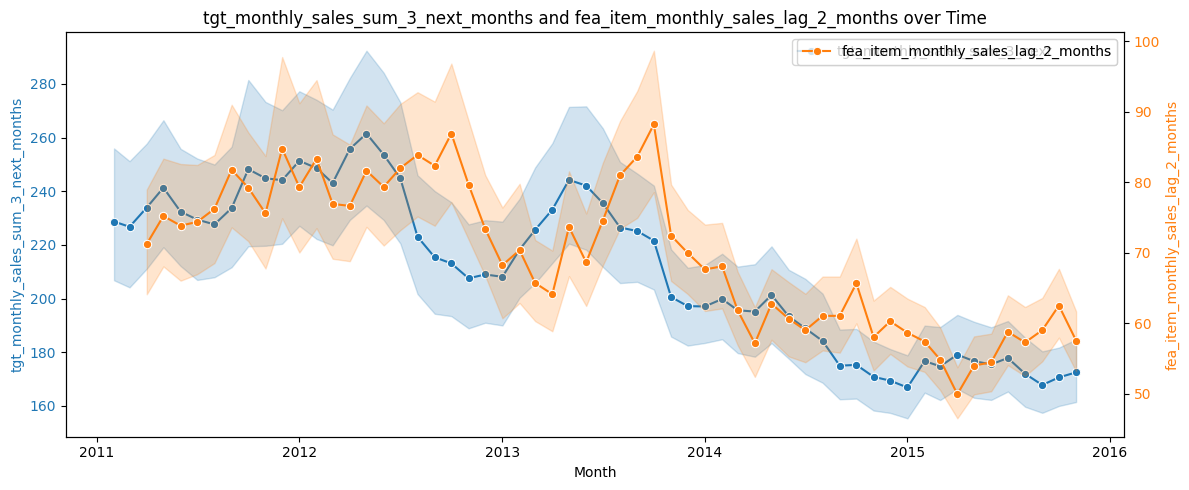

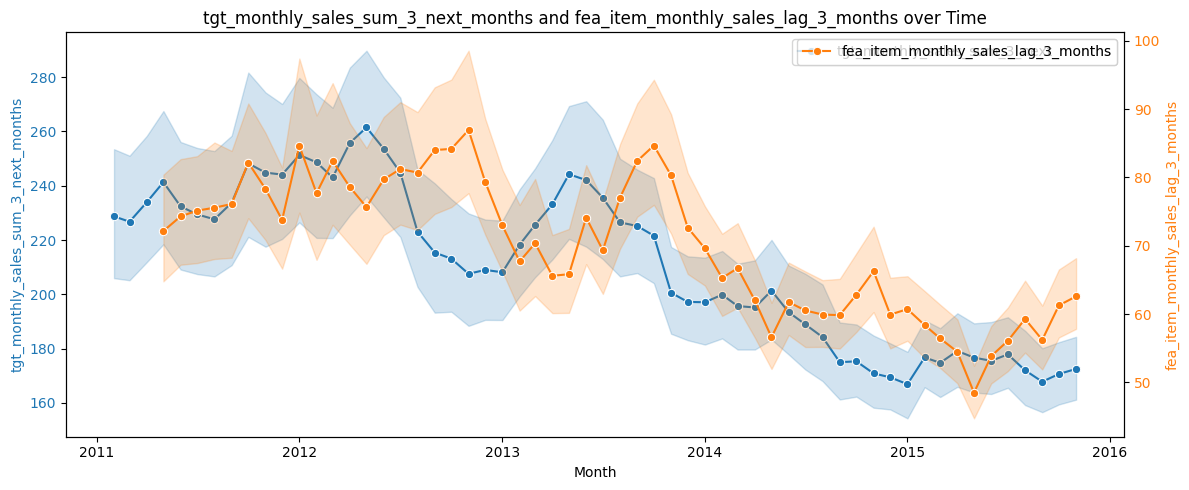

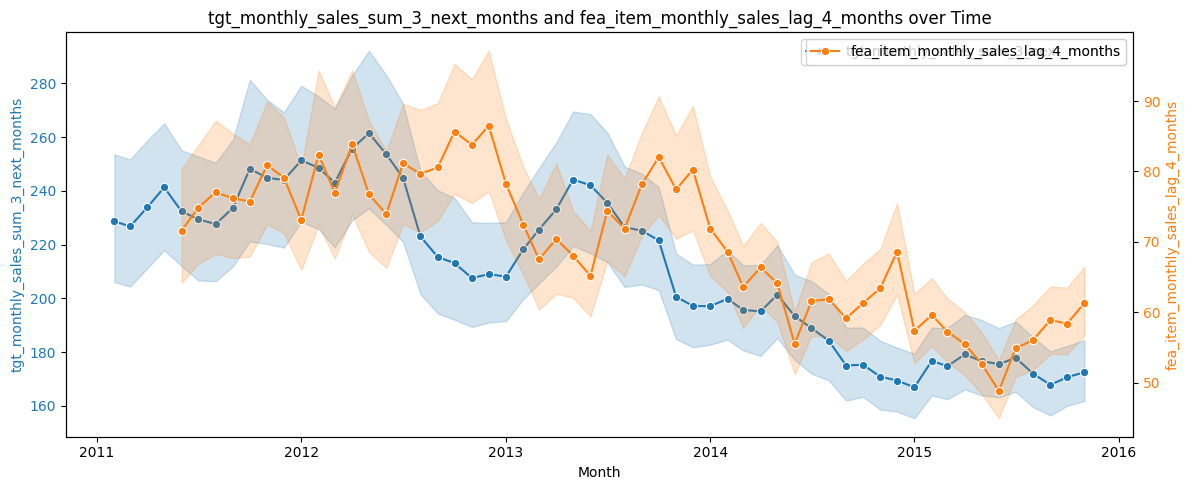

In [8]:
# the feature for standard deviation as is might be misleading as it indicates trend.
# The lower the standard deviation the lower the value. This might be good to switch for coefficient of variation instead.
plot_tgt_vs_feature("fea_item_monthly_sales_lag_1_months")
plot_tgt_vs_feature("fea_item_monthly_sales_lag_2_months")
plot_tgt_vs_feature("fea_item_monthly_sales_lag_3_months")
plot_tgt_vs_feature("fea_item_monthly_sales_lag_4_months")
# I do believe this features will become relevant after the application of differencing. 

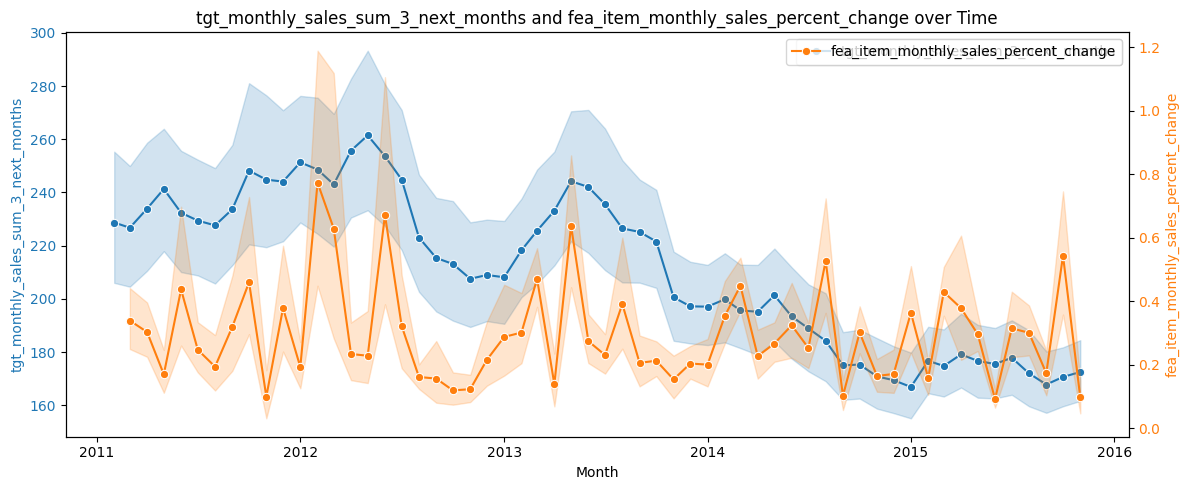

In [ ]:
# This feature seems to be very noisy even though somewhat useful. 
plot_tgt_vs_feature("fea_item_monthly_sales_percent_change")


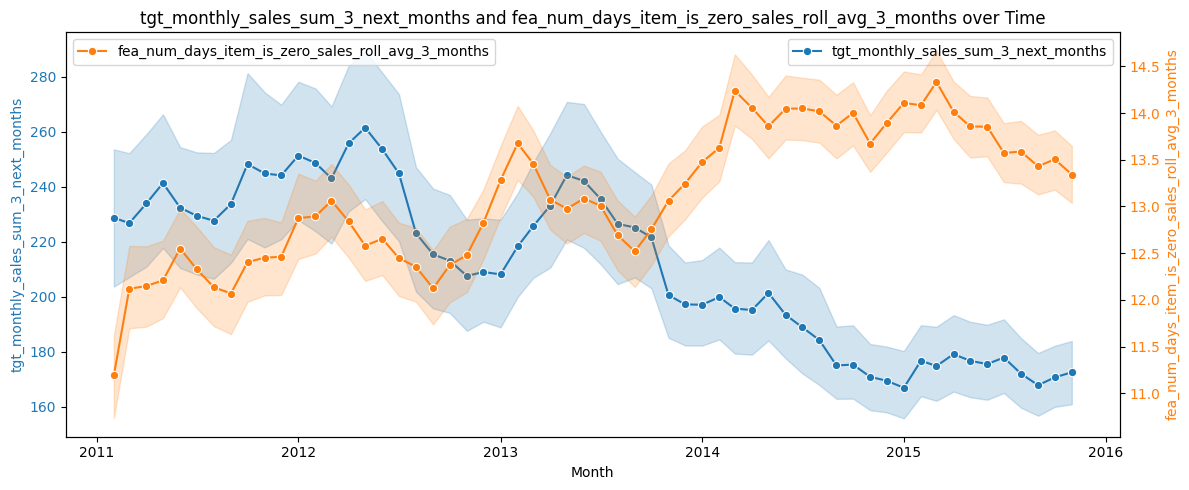

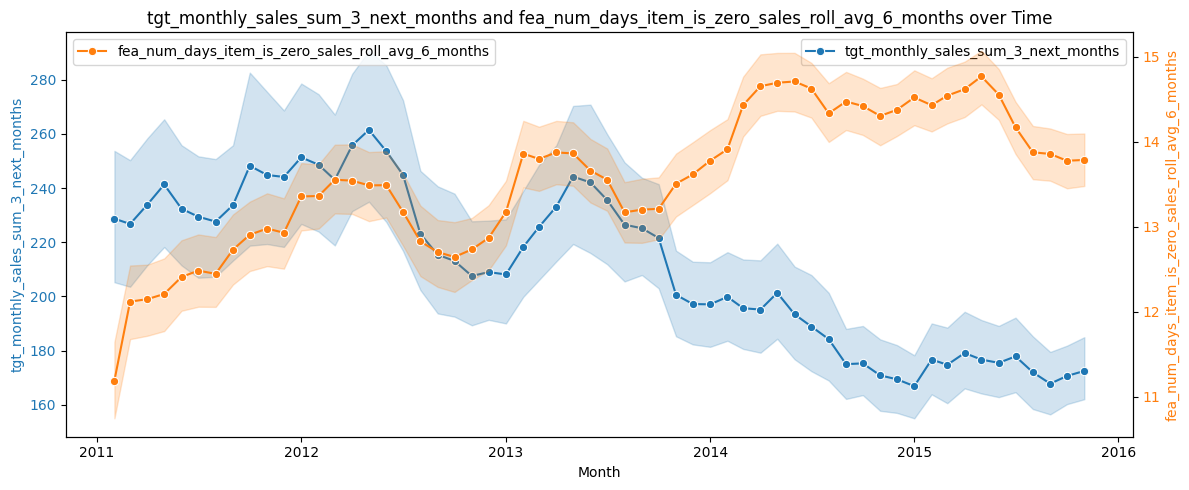

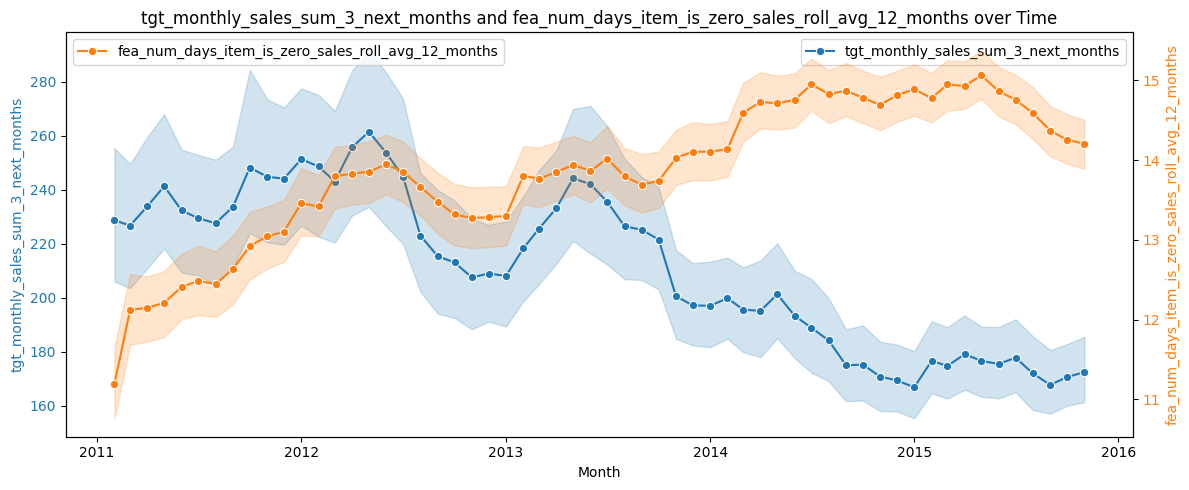

In [12]:
# This is interesting to see. As sales have decreased so have the number of days with zero sales per month. 
plot_tgt_vs_feature("fea_num_days_item_is_zero_sales_roll_avg_3_months")
plot_tgt_vs_feature("fea_num_days_item_is_zero_sales_roll_avg_6_months")
plot_tgt_vs_feature("fea_num_days_item_is_zero_sales_roll_avg_12_months")

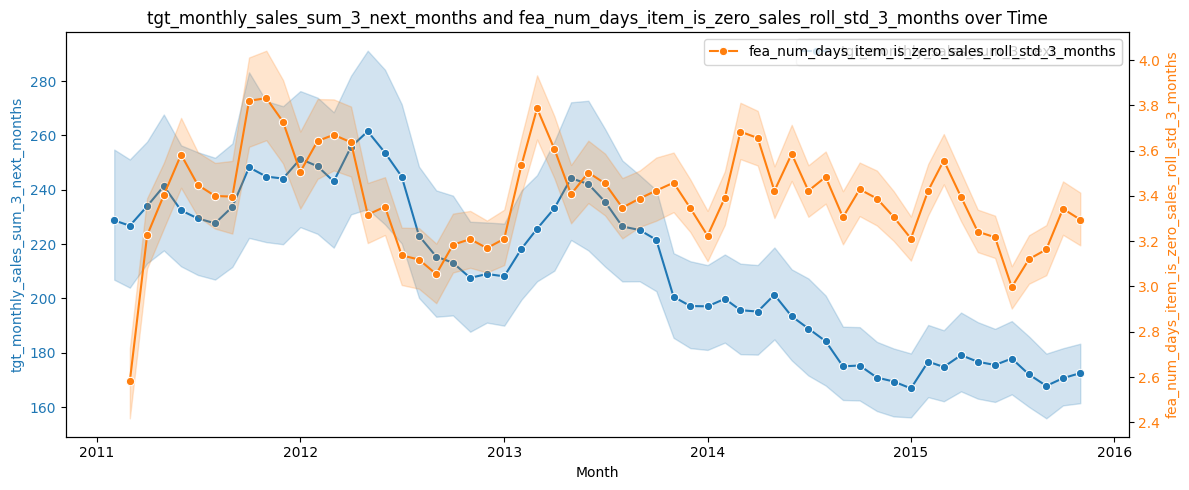

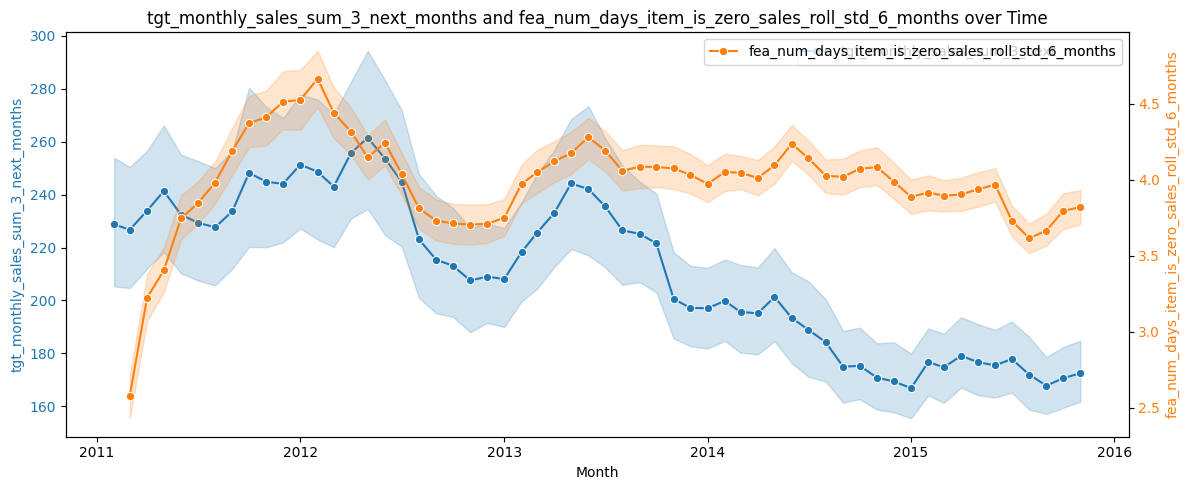

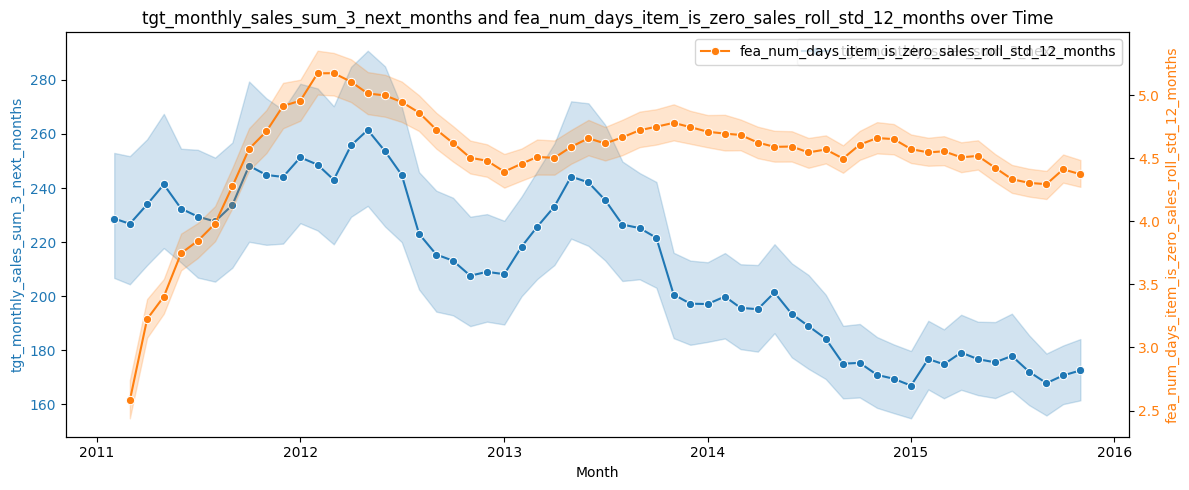

In [ ]:
# Here I have the same feedback as before: Maybe a coefficient of variation would be better than standard deviation.
plot_tgt_vs_feature("fea_num_days_item_is_zero_sales_roll_std_3_months")
plot_tgt_vs_feature("fea_num_days_item_is_zero_sales_roll_std_6_months")
plot_tgt_vs_feature("fea_num_days_item_is_zero_sales_roll_std_12_months")

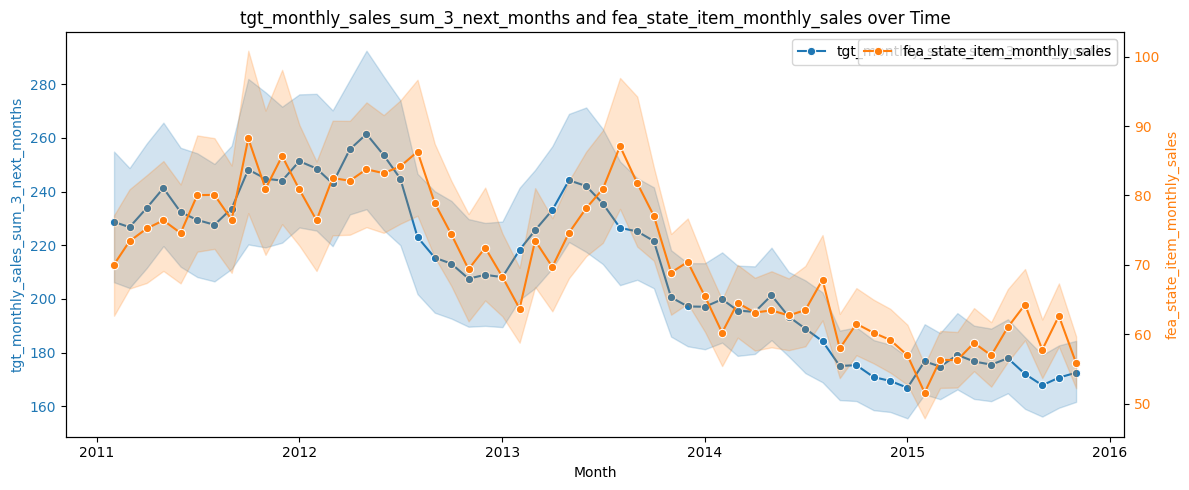

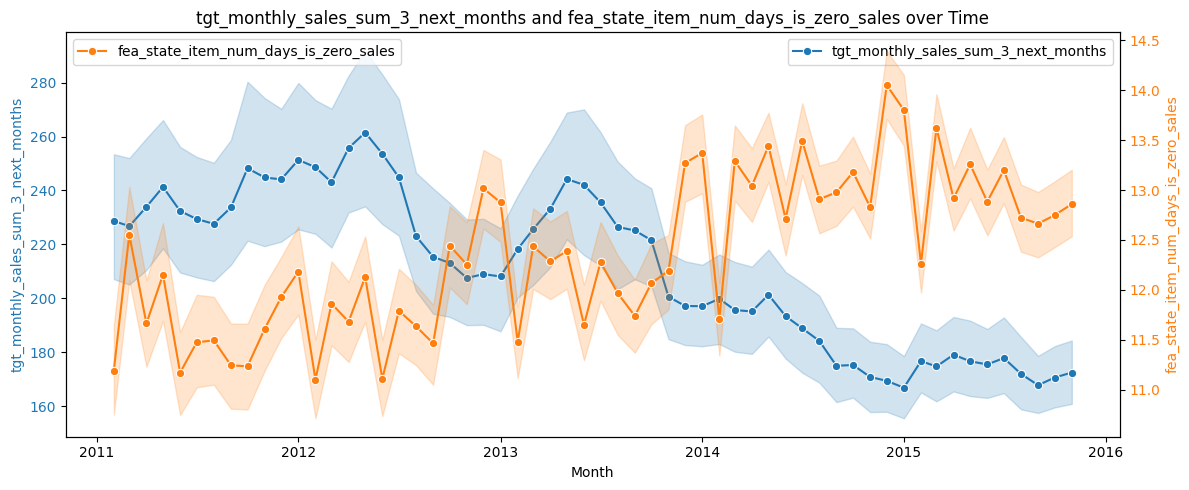

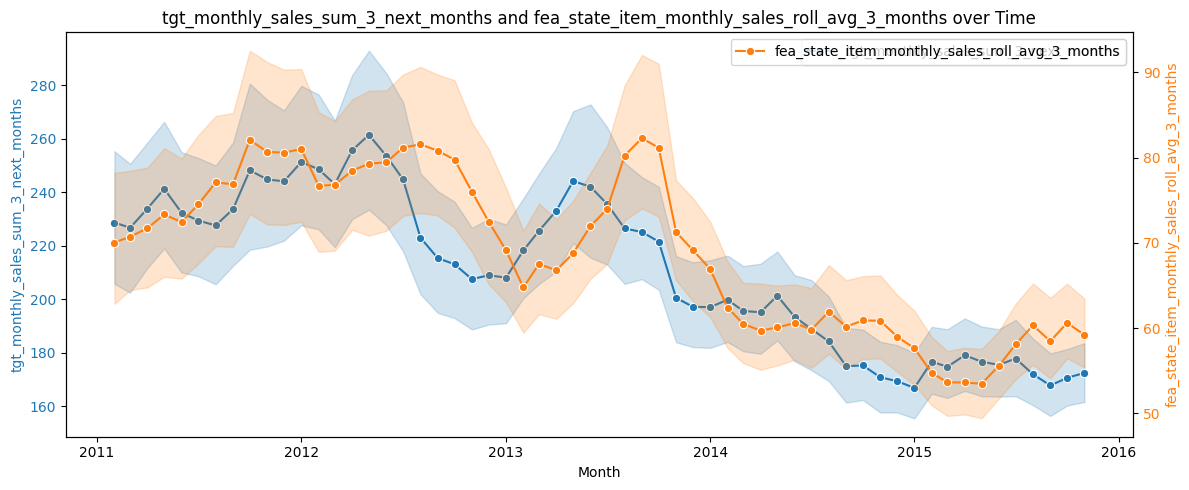

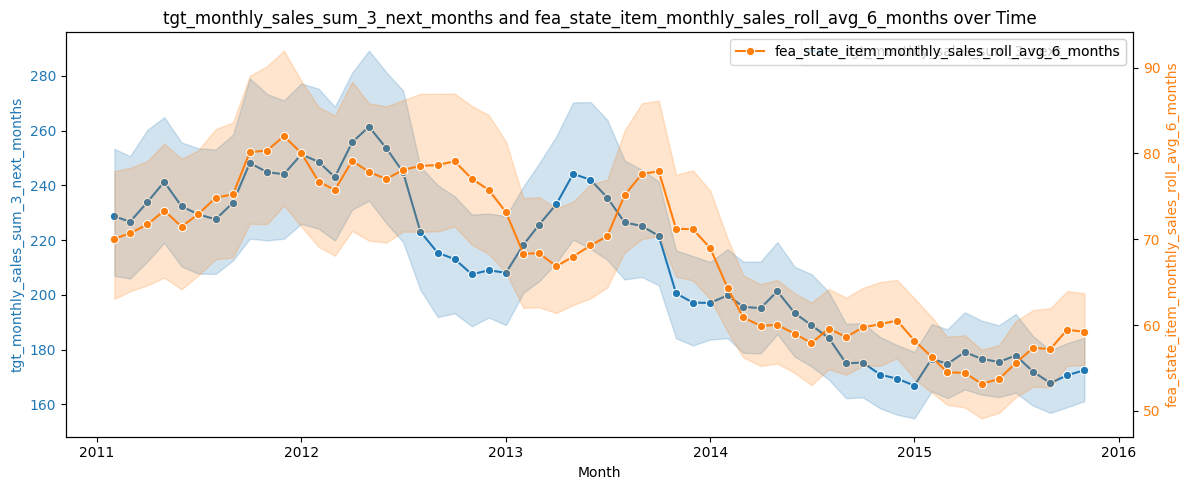

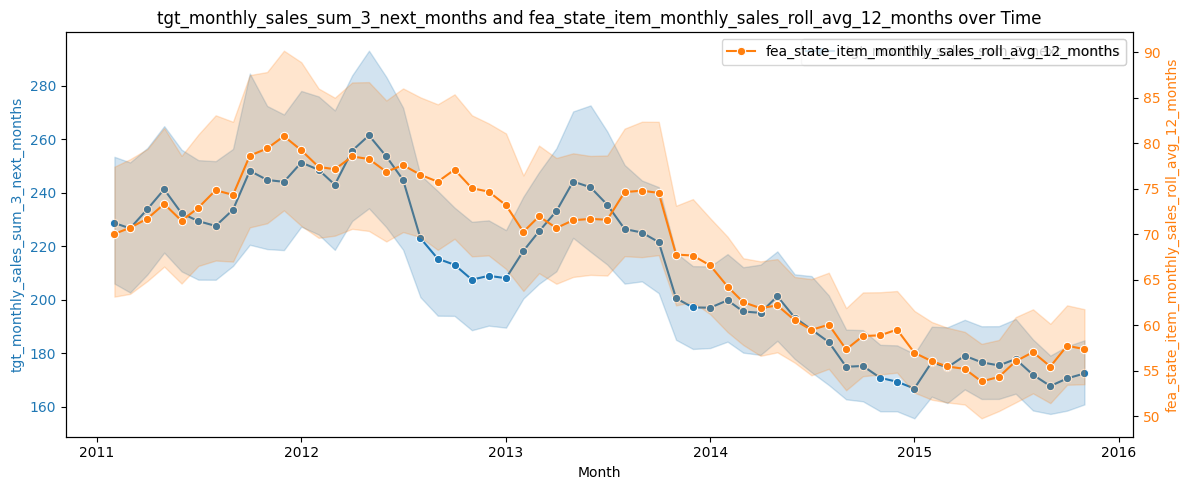

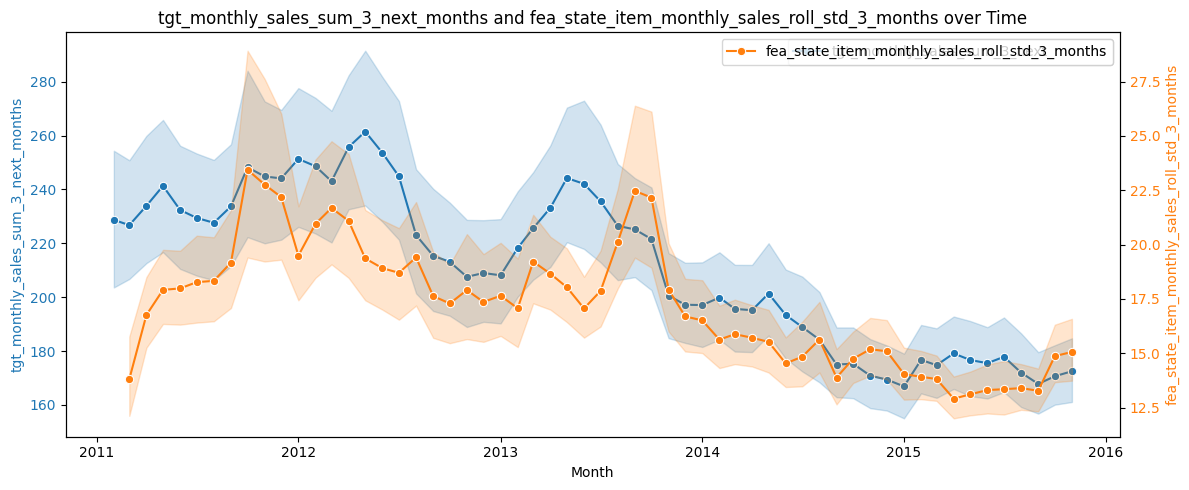

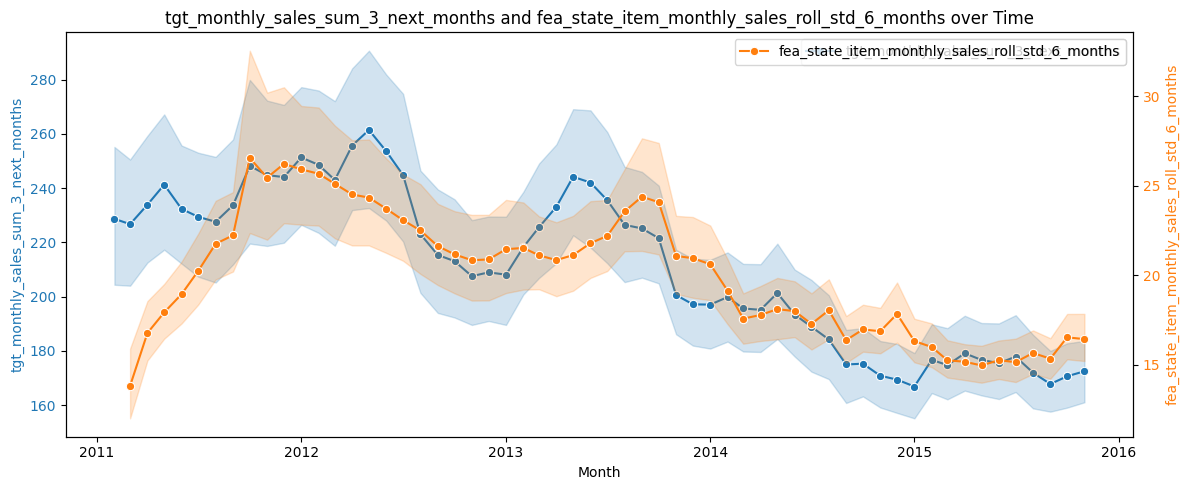

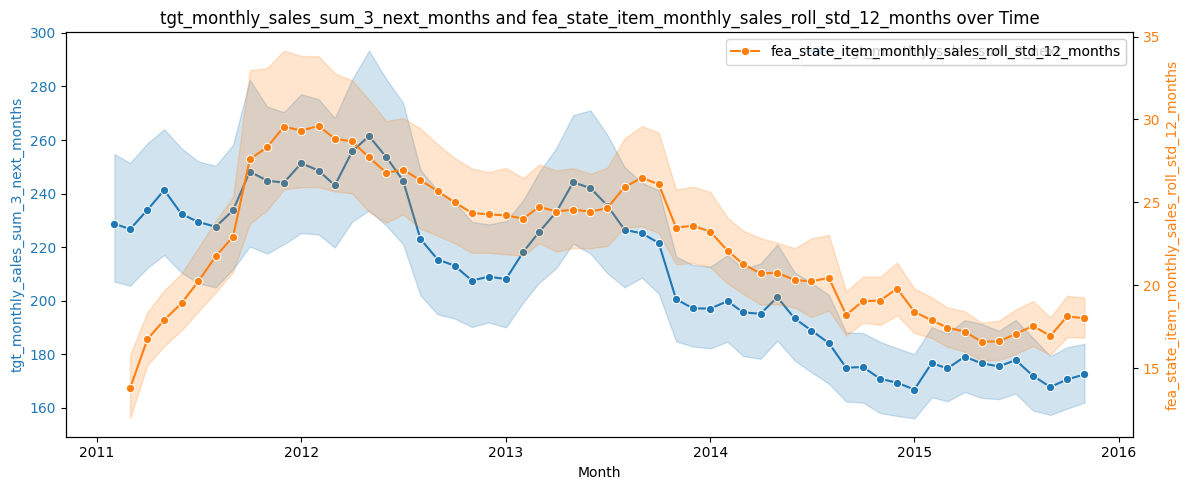

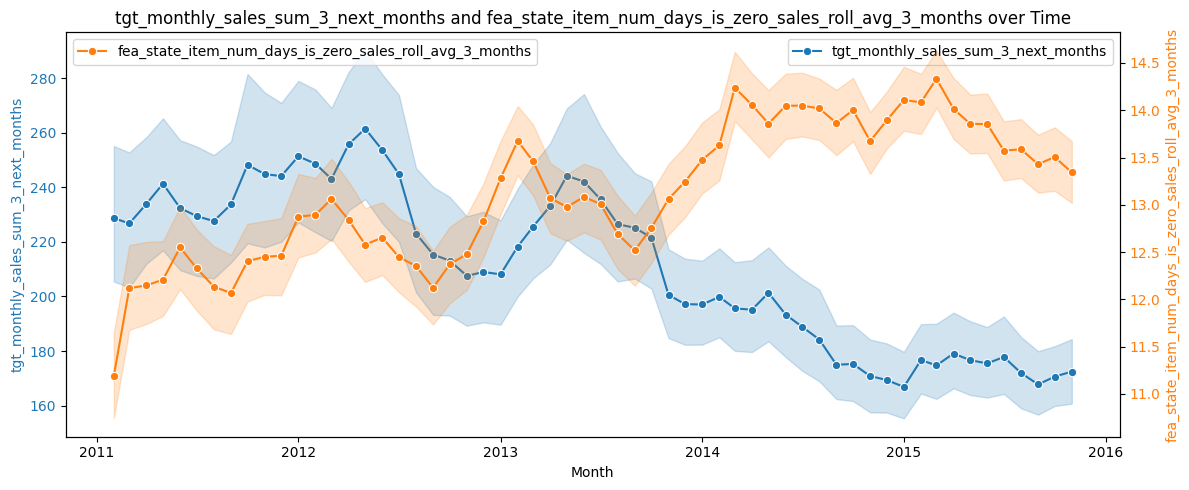

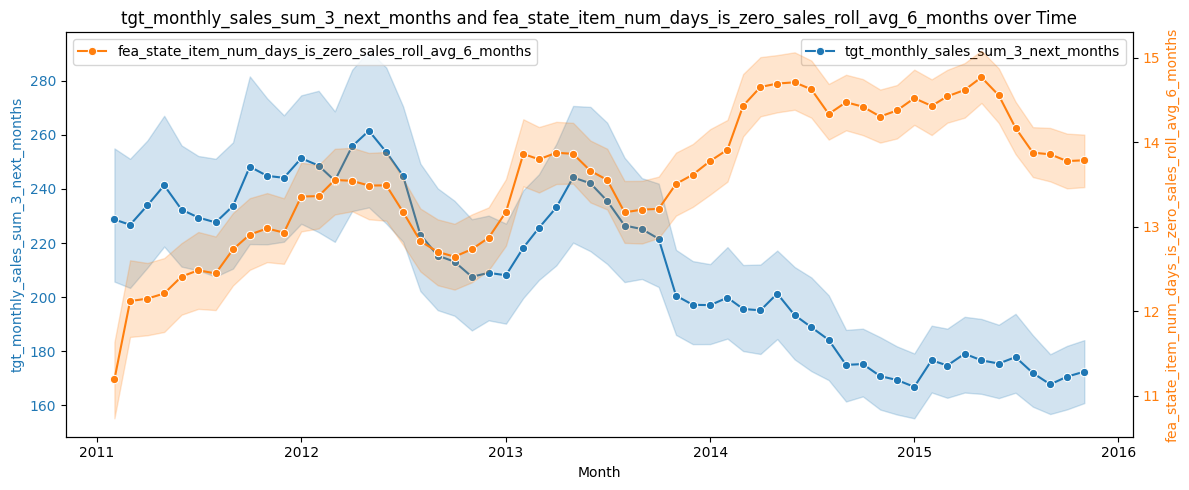

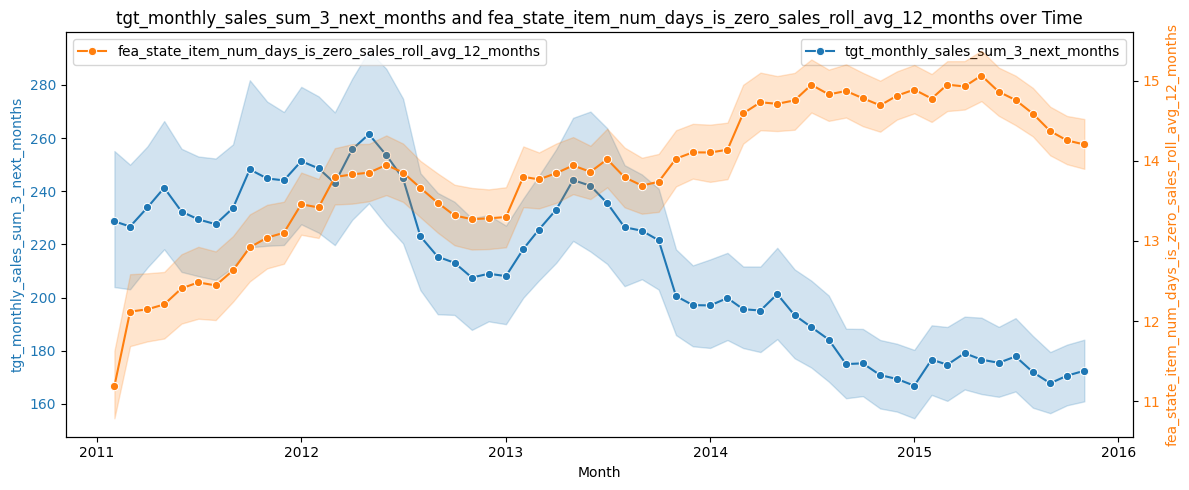

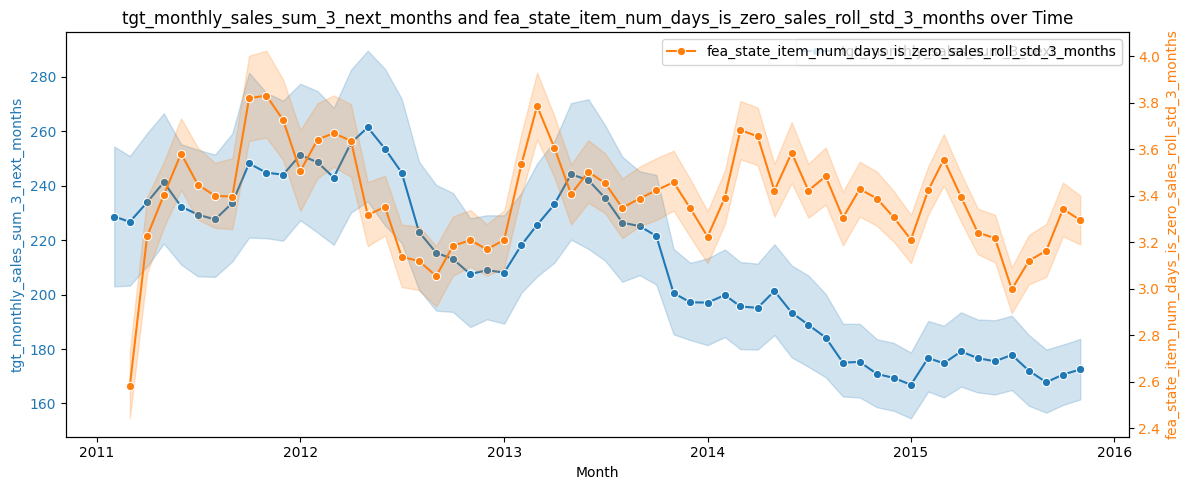

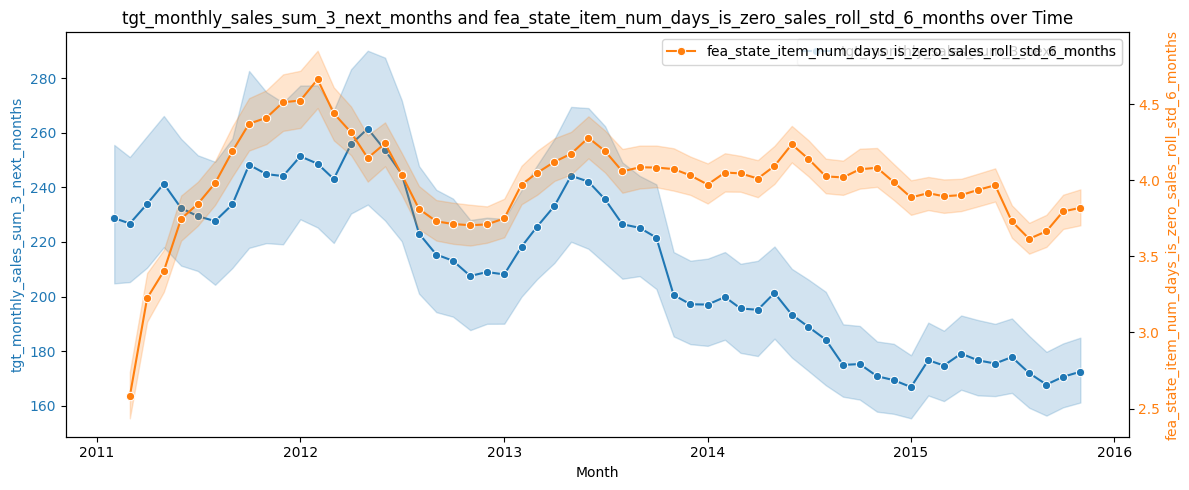

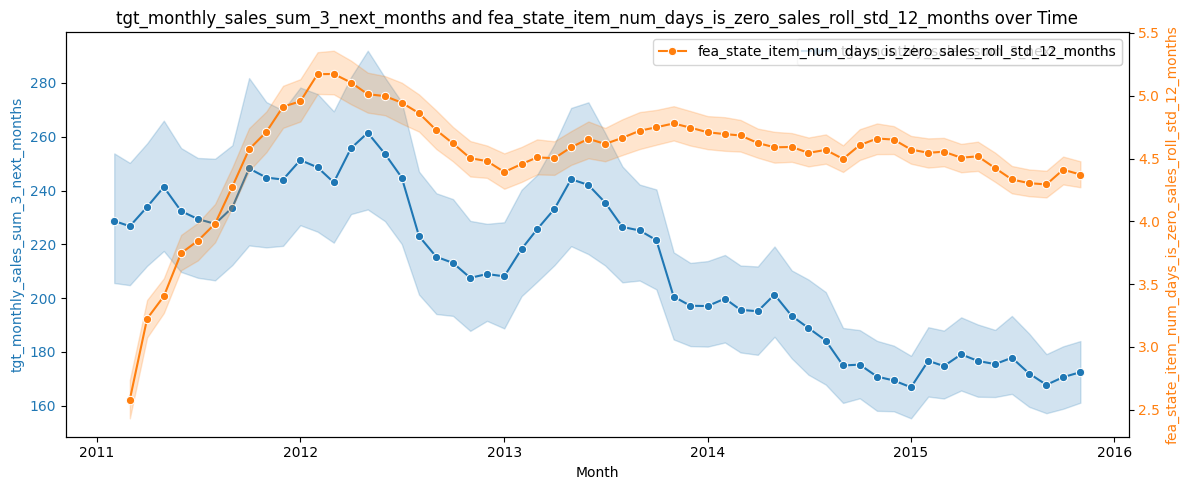

In [19]:
# State level features seem like a good indicator.
plot_tgt_vs_feature("fea_state_item_monthly_sales")
plot_tgt_vs_feature("fea_state_item_num_days_is_zero_sales")
plot_tgt_vs_feature("fea_state_item_monthly_sales_roll_avg_3_months")
plot_tgt_vs_feature("fea_state_item_monthly_sales_roll_avg_6_months")
plot_tgt_vs_feature("fea_state_item_monthly_sales_roll_avg_12_months")
plot_tgt_vs_feature("fea_state_item_monthly_sales_roll_std_3_months")
plot_tgt_vs_feature("fea_state_item_monthly_sales_roll_std_6_months")
plot_tgt_vs_feature("fea_state_item_monthly_sales_roll_std_12_months")
plot_tgt_vs_feature("fea_state_item_num_days_is_zero_sales_roll_avg_3_months")
plot_tgt_vs_feature("fea_state_item_num_days_is_zero_sales_roll_avg_6_months")
plot_tgt_vs_feature("fea_state_item_num_days_is_zero_sales_roll_avg_12_months")
plot_tgt_vs_feature("fea_state_item_num_days_is_zero_sales_roll_std_3_months")
plot_tgt_vs_feature("fea_state_item_num_days_is_zero_sales_roll_std_6_months")
plot_tgt_vs_feature("fea_state_item_num_days_is_zero_sales_roll_std_12_months")

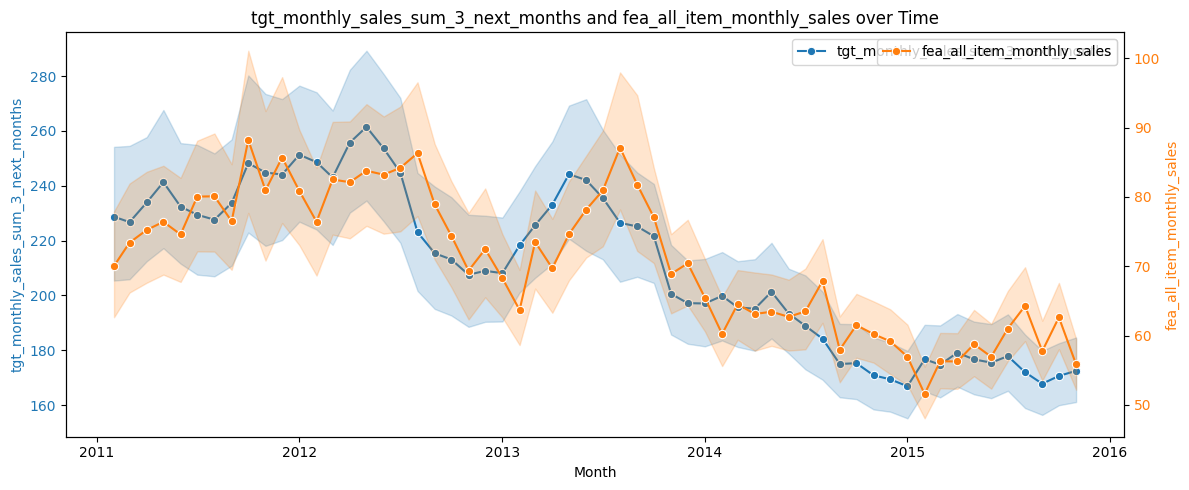

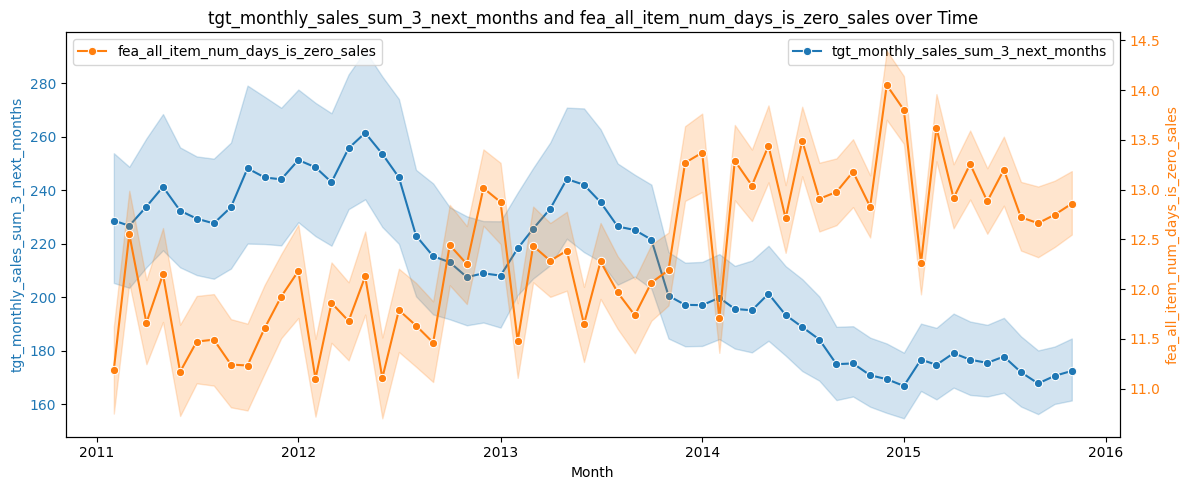

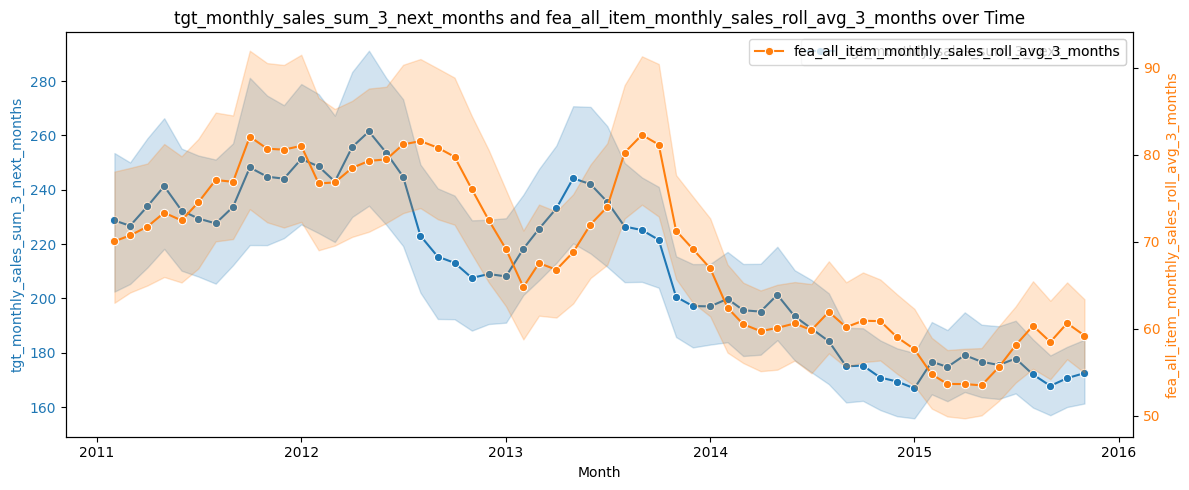

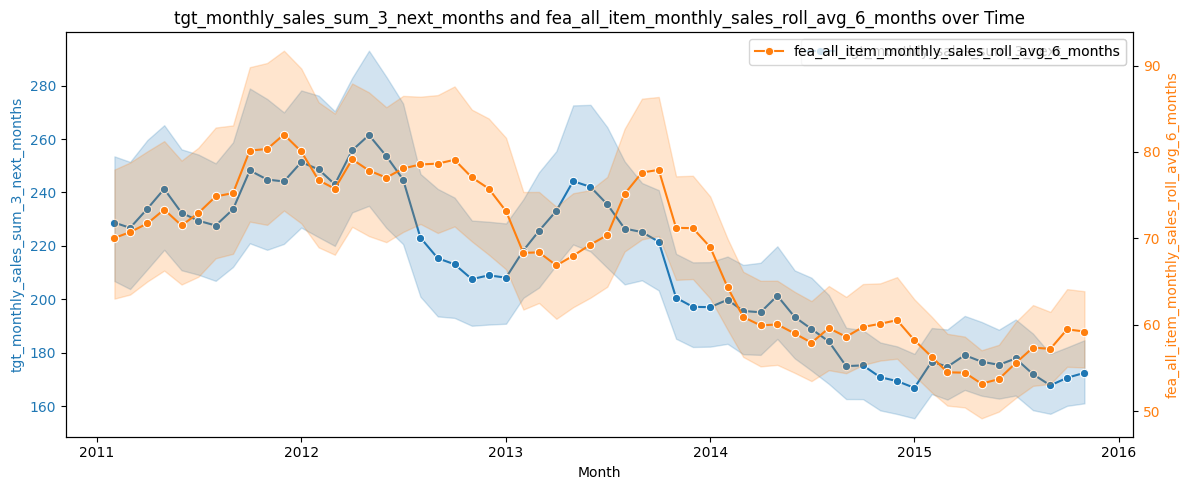

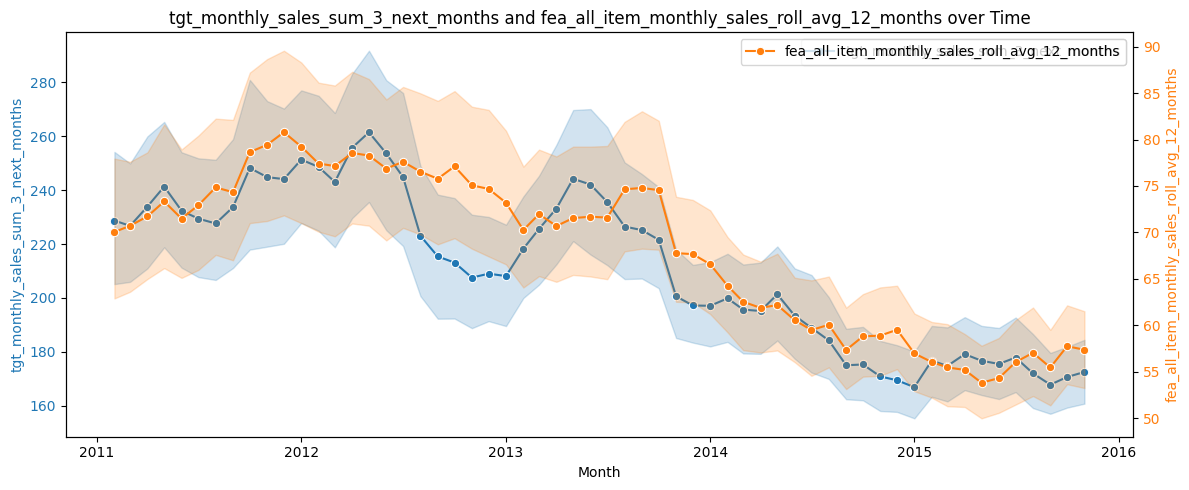

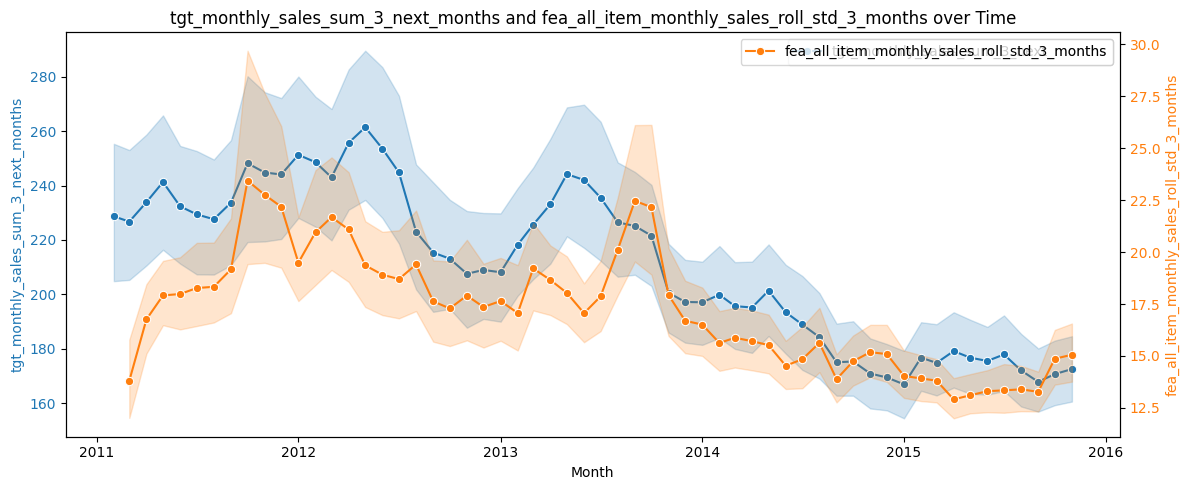

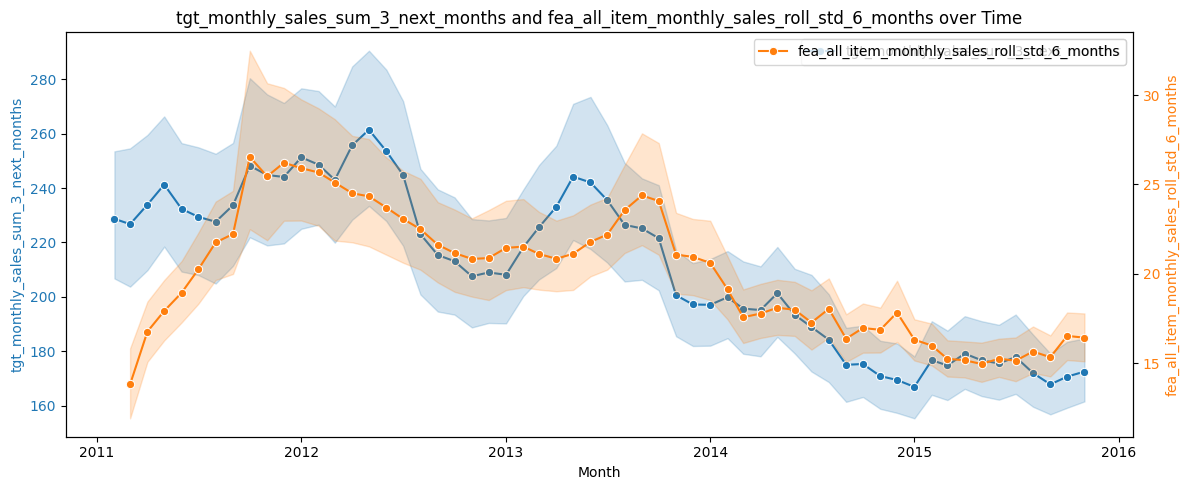

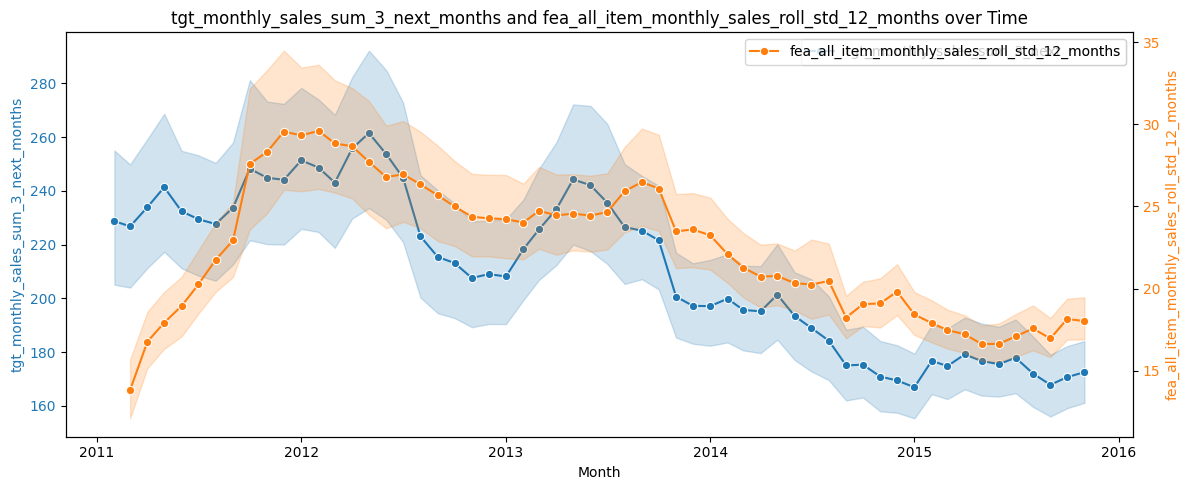

In [ ]:
# State level features seem like a good indicator.
# The curve for all items is somewhat similar. 
plot_tgt_vs_feature("fea_all_item_monthly_sales")
plot_tgt_vs_feature("fea_all_item_num_days_is_zero_sales")
plot_tgt_vs_feature("fea_all_item_monthly_sales_roll_avg_3_months")
plot_tgt_vs_feature("fea_all_item_monthly_sales_roll_avg_6_months")
plot_tgt_vs_feature("fea_all_item_monthly_sales_roll_avg_12_months")
plot_tgt_vs_feature("fea_all_item_monthly_sales_roll_std_3_months")
plot_tgt_vs_feature("fea_all_item_monthly_sales_roll_std_6_months")
plot_tgt_vs_feature("fea_all_item_monthly_sales_roll_std_12_months")
